In [25]:
from __future__ import print_function
import collections
import os
import string
#nltk.download()
import sklearn
from sklearn import datasets
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from itertools import islice
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# part 2:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils.extmath import density
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import re
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from time import time
from sklearn.model_selection import GridSearchCV
import warnings
#warnings.simplifier(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


# Part 1 - Pre Processing

In [26]:
# explore the dataset:


dataSet=[]
data_test=[]

# <document,list of words> for trainX -> after being cleaned
documentsTrain = {}

# <document,list of words> for testX -> after being cleaned
documentsTest = {}

mostFrequentInCorpus={} # dictionary that contains the most common words in the whole corpus

#dictionaries that save data ONLY for the train dataset
# <cat,no.docs>
catDocs = {} 
# <cat,no.terms,frequency>
catTerms = {}
# document and its categories
dicCategory = {}
#data of the dataset
data = ''
# vector clean text for each document train:
_train_clean_Data = []


### First, we will load the data from the given path

In [27]:
def makeDataSet(path):
   temp=sklearn.datasets.load_files(path, description=None, categories=None, load_content=True, shuffle=True, encoding=None, random_state=0)
   data = temp.data
   return temp

dataSet = makeDataSet("C:\\Users\\Estif\\Downloads\\ohsumed-first-20000-docs.tar\\ohsumed-first-20000-docs"
            "\\training")
data_test = makeDataSet("C:\\Users\\Estif\\Downloads\\ohsumed-first-20000-docs.tar\\ohsumed-first-20000-docs"
            "\\test")

In [28]:
# merge 2 dictionaries
def mergeDicts(dic1, dic2):
    input = [dic1, dic2]
    return sum((Counter(dict(x)) for x in input), Counter())

# count dictionary's words frequency
def makeFrequencyDic(words):
    wordFreq=[words.count(p) for p in words]
    return dict(zip(words,wordFreq))
    

# update frequency for categories
def updateCategories(categories,words):
    wordsFreq= makeFrequencyDic(words)
    for category in categories:
        if category in catTerms:
            frequencyDic=catTerms[category]
            mergedDic=mergeDicts(frequencyDic,wordsFreq)
            catTerms[category] = mergedDic
        else:
            catTerms[category] = wordsFreq
            
# sort frequency dic in descending order
def sortFreqDict(freqdict):
    sorted = [(freqdict[key], key) for key in freqdict]
    sorted.sort()
    sorted.reverse()
    return sorted

# "Return first n items of the iterable as a list"
def take(n, iterable):
    return list(islice(iterable, n))


### Secondly, we will clean the data

In [29]:
def cleanData(dataSet,documents):
   counter = 0
   for file in dataSet.filenames:
       data = dataSet.data[counter]
       category = os.path.basename(os.path.dirname(file))
       fileName = os.path.basename(file)
       documents[fileName] = word_tokenize(data.decode("utf-8"))
       counter = counter+1
       # <category, num of docs>
       if category in catDocs:
           catDocs[category] = catDocs[category] +1
       else:
           catDocs[category] = 1
           # <doc,list of categories>
       if fileName not in dicCategory:
           dicCategory[fileName] = []
           dicCategory[fileName].append(category)
       else:
           dicCategory[fileName].append(category)
   # stop words filtration ,lowercase and stemmig
   stop_words = stopwords.words('english')
   moreStopWords=['p', '+/-', '-/+']
   stop_words += set(string.punctuation)
   stop_words.extend(moreStopWords)
   #stem


   for key, value in documents.items():
       words = documents[key]
       ps = PorterStemmer()
       #filtered_sentence = [w for w in words if not w in stop_words]
       filtered_sentence = []
       for w in words:
           w = w.lower()
           if w not in stop_words:
               if len(w)>1:
                   try:
                       filtered_sentence.append(ps.stem(w))
                   except Exception as inst:
                       filtered_sentence.append(w)
       documents[key] = filtered_sentence
       updateCategories(dicCategory[key],filtered_sentence)
       
   return documents


#####Function that find the most common words in the corpus

In [30]:
def findMostFrequentInCorpus():
    global mostFrequentInCorpus
    mostFrequentInCorpus=sortFreqDict(mostFrequentInCorpus) #sort dic by frequency
    top5 = dict((val, key) for (key, val) in mostFrequentInCorpus)
    top5 = dict(take(5, top5.items()))
    return top5
    

In [35]:
from IPython.display import display


def makeTables(dataSet):
    global catTerms
    print(catTerms.get('C01'))
    global mostFrequentInCorpus
    numCat = len(dataSet.target_names)
    # print number of categories
    print('Number of categories are:', numCat)
    # make categories and number of docs for each of them table
    sortedCategories=collections.OrderedDict(sorted(catDocs.items()))
    categoriesArr = []
    for category, numFiles in sortedCategories.items():
        categoriesArr.append([category,numFiles])

    categorisDocumentsDF=pd.DataFrame(categoriesArr, columns=['Category', 'NumberOfFiles'])
    display(categorisDocumentsDF)

    # make frequencies table
    # first, order by category
    catTerms = collections.OrderedDict(sorted(catTerms.items()))

    categoriesArr = []
    for category, freqDic in catTerms.items():
        lineArr = []
        lineArr.append(category)
        freqDic=sortFreqDict(freqDic) #sort dic by frequency
        top10 = dict((val, key) for (key, val) in freqDic)
        top10 = dict(take(10, top10.items()))
        print("category: "+top10.items())

        mostFrequentInCorpus=mergeDicts(top10,mostFrequentInCorpus)
        
        wordsLine=[]
        
        for word,freq in top10.items():
            termAndfreq=[word,freq]
            lineArr.append(termAndfreq)
            wordsLine.append(termAndfreq)
        
        categoryPlot = pd.DataFrame(wordsLine, columns = ['Word', 'Count'])    
        ax = categoryPlot.plot.bar(title ="10 most frequent terms in category: " + 
                                          category, x='Word', y='Count')

        categoriesArr.append(lineArr)
        
        
        x_offset = -0.4
        y_offset = 2
        for p in ax.patches:
          b = p.get_bbox()
          val = b.y1 + b.y0    
          ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
        
        

    termsFreqDF=pd.DataFrame(categoriesArr, columns=['Category','term 1','term 2','term 3','term 4','term 5','term 6','term 7','term 8','term 9','term 10'])
    display(termsFreqDF)
    df2 = pd.DataFrame(termsFreqDF)
    df2.transpose()
    df2.style


###Lastly, we will make the requires tables for the data TRAIN set - in order to explore it

In [36]:
def makeFrequentGraph():
    global catTerms
    catTerms=collections.OrderedDict(sorted(catTerms.items())) # first, order by category
    for category, wordsDic in catTerms.items():
        words_count_docs = {} # saves how many documents each word is in this category. 
          
        for word in wordsDic.keys(): ## initalize all to 0
            words_count_docs[word]=0

        for word in wordsDic.keys(): # go through all the words of this category
            for doc in dicCategory: 
                if category in dicCategory[doc] and word in documentsTrain[doc]: # if that word is in that document and if that doucment belongs to this category
                  words_count_docs[word]+=1
                  
        # transform it to DF
        lines=[]
        for word,numDocs in words_count_docs.items():
            line=[word,numDocs]
            lines.append(line)
            
        wordsDocs_DF=pd.DataFrame(lines, columns=['word',category+''])
        uniqueCount=set(wordsDocs_DF[category+''])
        fig=wordsDocs_DF.hist(column=category+'',bins=len(uniqueCount))
        plt.ylabel("# terms")
        plt.xlabel("Frequency of terms (number of documents)")
        plt.show(fig)


In [37]:
##def clean_text(X_text_data):
##   stop_words = stopwords.words('english')
##   moreStopWords=['p', '+/-', '-/+', 'patients', 'may']
##   stop_words += set(string.punctuation)
##   stop_words.extend(moreStopWords)
##   
##
##   new_x_data=[]
##   for text in X_text_data:
##       words = text.split(' ')
##       ps = PorterStemmer()
##       filtered_sentence = []
##       for w in words:
##           w = w.lower()
##           if w not in stop_words:
##               if len(w)>1:
##                   try:
##                       filtered_sentence.append(p##s.stem(w))
##                   except Exception as inst:
##                       filtered_sentence.append(w)
##       new_x_data.append(' '.join(filtered_sentence))
##   return new_x_data


## Explore the dataset:
* Clean Dataset.
* Display categories and documents frequency table.
* Display categories and 10 most common words frequency table.
* Display categories and 10 most common words frequency graphs.

In [38]:

#train
documentsTrain = cleanData(dataSet,documentsTrain)

makeTables(dataSet)







text=''
#_train_clean_Data=clean_text(_train_clean_Data)

#print(len(_train_clean_Data))
#for key,value in documentsTrain.items():
#    text = #
#    _train_clean_Data.append(text)
 
 
y_train, y_test = dataSet.target, data_test.target   


Counter({'patient': 2919, 'infect': 1902, 'treatment': 795, 'group': 774, 'case': 732, 'diseas': 720, 'use': 630, 'studi': 594, 'clinic': 576, 'therapi': 534, 'may': 492, 'associ': 477, 'less': 474, 'isol': 471, 'caus': 444, 'result': 441, 'effect': 432, 'children': 426, 'increas': 402, 'cultur': 399, 'bacteri': 384, 'report': 384, 'blood': 372, 'two': 360, 'antibiot': 357, 'one': 354, 'day': 342, 'control': 330, 'present': 330, 'organ': 330, 'rate': 315, 'compar': 312, 'risk': 312, 'pylori': 312, 'test': 309, 'occur': 309, 'complic': 309, 'develop': 306, 'treat': 297, 'human': 291, 'cell': 288, 'syndrom': 288, 'year': 285, 'evalu': 285, 'antibodi': 282, 'age': 276, 'posit': 276, 'level': 273, 'system': 270, 'sepsi': 270, 'also': 267, 'type': 264, 'activ': 261, 'month': 255, 'significantli': 255, 'hospit': 252, 'three': 249, 'chronic': 249, 'follow': 246, 'found': 243, 'pulmonari': 243, 'differ': 237, 'respons': 237, 'receiv': 237, 'diagnosi': 237, 'immunodefici': 237, 'suggest': 234, 

,Category,NumberOfFiles
0,C01,846
1,C02,316
2,C03,130
3,C04,2326
4,C05,566
5,C06,1176
6,C07,200
7,C08,946
8,C09,250
9,C10,1242


TypeError: can only concatenate str (not "dict_items") to str

In [ ]:
makeFrequentGraph()


In [ ]:
top5=findMostFrequentInCorpus()
print('top 5 words in the corpus are:')
print(top5)


##Expected challenges
* The first challenge was dealing with frequent words that appeard in multiple categeries. In consequence, the uniqueness of each of the categories was damaged since the same words appeared in most of these categories (The reason for that is because the corpus has one theme - medical world, which result in medical related words that re-appear in most of the corpus's documents). We could call these words "noise". Such words are: patients, may and so on. In order to solve this problem, we decided to find the most frequent words in the WHOLE corpus and omit them from the top 10 list of each of the categories. This solution will help us to explore the dataset in more depth and examine the words that are unique to each of the corpus's categories (So we will learn why certian words appear in ONE particular category). 
We wanted to see if we have congruences between different categories, especially in common words (that are not stop words). If we have common corpus words (that are not stop words) that appear in 2 categories and more, then we would except that these said categories (with the congreuence) will be less distinguished by the model. Furthermore, if there are cateroeis that belong to a specific category, then it will be easier to identify documents that belong to this category. Thesefacts link directly to our next challenge. 
We decided to display our frequent words (for EACH category) in 2 forms - the first graph displays the 10 top words in each category and its number of appearences in this category. The second graph represents the words frequency in documents in each category (not only the top10, since we want to see in how many documents the most dominent words in each category appears

* Another challenge, that is being caused directly from the first one, is finding the amout of common corpus words to ommit. Meaning, we wanted to find how many corpus frequent words we dotn want to include in our top 10 caterogies exploration. On the one hand, removing MANY corpus common words resulted in lower model's accuracy. On the other hand, reducing a low number of corpus common words, resulted in a higher model's accuracy. The second option seemmed more prominenet to us, but this accuracy won't be very faithul since it its model will include many words that appear too many times in corpus (noise). We wanted to find the balance, meaning - finding the right number of common corpus words to omit, so it wont hurt the model's accuracy and still make it reliable so we can estimate the dataset's features in an effactive way. We decided to omit 5 common words as a result. We wrote a function named FindMostCommonCorpusWords that find the 5 most frequent words in the corpus. We then added these words to the stop words list manually.

* The last challenge we faced is the appearnces of many "un real" words, such as: p, +/- and so on (The stemming and stop words proceess haven't removed these). This resulted in data'set noise since these words appeared in many of the top 10 categories word and wouldn't show their true uniqueness. Therefore, we had to omit such words from the dataset's explorations, by adding them to the stop words list. After doing so, we managed to explore each of the categories in mroe depth and see which REAL words are common to its of these said categories. 
* for the second part, we face the challenge of finding out which paramter's values are bes. We would also need to understand the definitions of each ot them and their effect of each of the machine learning methods we will examine. 




##Part 2: Document Classification


###Use features extractions: bag of words and TD-IDF

### Building x_test data (that went though the pre processing of part one). It will be used for optimazing the results later on.

In [21]:
#test
documentsTest = cleanData(data_test,documentsTest)

_test_clean_Data = []

# vector clean text for each document test: 
text=''
for key,value in documentsTest.items():
    text = ' '.join(value)
    _test_clean_Data.append(text)



###Bag of words feature extraction

In [33]:
# bag of words feature extraction:

vectorizer = CountVectorizer()
BOW_train = vectorizer.fit_transform(dataSet.data)

BOW_test = vectorizer.transform(data_test.data)


### Tf-IDF feature extraction

In [34]:
# TF-IDF feature extraction:

Tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
#calculate TF-IDF of terms in documents
Tfidf_train = Tfidf_vectorizer.fit_transform(dataSet.data)
Tfidf_test = Tfidf_vectorizer.transform(data_test.data)

### First we will evaluate SVM and NB machine learnings methods and display it on graph to see the differences between each of them (Without making an optimal model). We will examine 4 combinations: SVM with bag of words, SVM with Tf-IDF, Naive Bayes with bag of words, Naive Bayes with Tf-IDF. 
It's important to note that we will do so without cleaning the x_train and x_test, since we want to see the predicting accuracy without the cleaning factor.

In [35]:
# evaluates how good the model is
def benchmark(clf, X_train, X_test): 
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [36]:
# compare between the different machine learning evaluations using plot 
def makePlot (results,FE_name):
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title(FE_name)
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

###Evaluating the models for each of the ML:SVM,Naive Bayes.


In [41]:
#helps to the models for each of the ML methods
def compareMLanFeatuers():
    
   # 1) This evaluation is done using TF-DF feature extraction
   results_Tfidf = []
   for clf, name in (
           (SGDClassifier(),"SVM Tf-IDF"),
           (MultinomialNB(),"Naive Bayes Tf-IDF")):
       print('-' * 80)
       print(name)
       results_Tfidf.append(benchmark(clf, Tfidf_train,Tfidf_test))
   makePlot (results_Tfidf,'Tf_IDF') # display the comparison between of the ML's methods.
   
   # 2) This evaluation is done using bag of words feature extraction 
   results_BOW = []
   for clf, name in (
           (SGDClassifier(),"SVM Bag of Words"),
           (MultinomialNB(),"Naive Bayes Bag of Words")):
       print('=' * 80)
       print(name,'Bag of words')
       results_BOW.append(benchmark(clf, BOW_train,BOW_test))
   makePlot (results_BOW ,'Bag of Words')  #display the comparison between of the ML's methods. 


--------------------------------------------------------------------------------
SVM Tf-IDF
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


train time: 0.645s
test time:  0.073s
accuracy:   0.439

--------------------------------------------------------------------------------
Naive Bayes Tf-IDF
________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


train time: 0.127s
test time:  0.085s
accuracy:   0.255



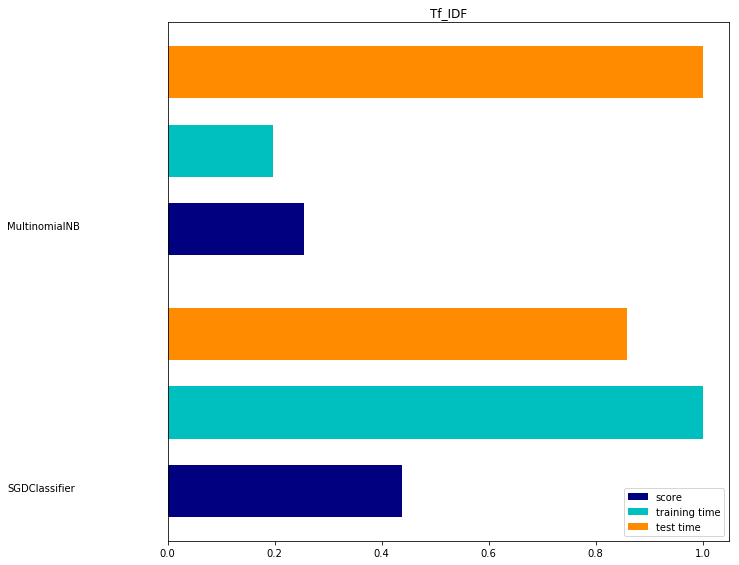

SVM Bag of Words Bag of words
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


train time: 0.870s
test time:  0.086s
accuracy:   0.323

Naive Bayes Bag of Words Bag of words
________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


train time: 0.147s
test time:  0.185s


accuracy:   0.391



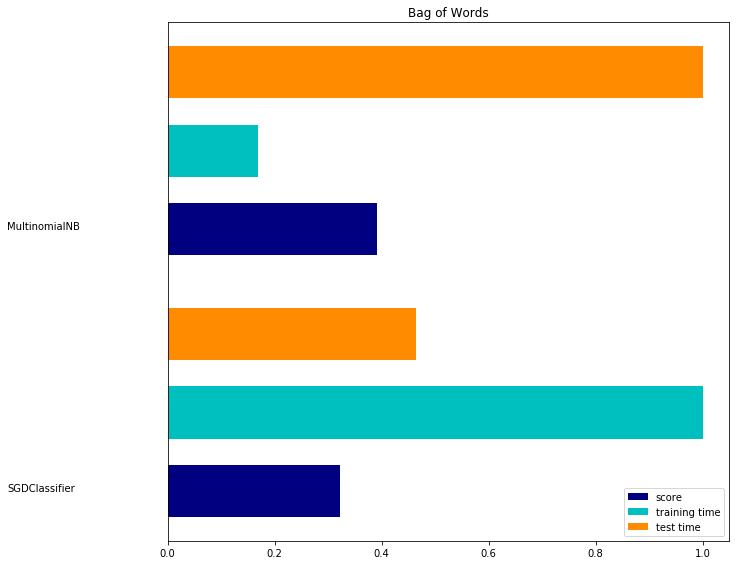

In [43]:
compareMLanFeatuers() # calls the function to compare the machine learning methods

### Now we will attempt to find the best parameters for each combinations of ML and feature extractions (4 overall), using pipeline and training the model

In [34]:
# this function recieves 1 feature extraction and 1 machine learning method, 
# and performes a classification in order to optimize the results
def bestClassifier(featureExtraction, clf, methodResults,parameters_clf,name):
    categories=list(catTerms.keys())
    _clf = Pipeline([('vect', featureExtraction), ('clf', clf)])
    gs_clf = GridSearchCV(_clf, parameters_clf, n_jobs=1)
    gs_clf = gs_clf.fit(dataSet.data, dataSet.target)
    prediction=gs_clf.predict(data_test.data)
    acc=metrics.accuracy_score(data_test.target,prediction)
    print(name)
    print('-----------------------')
    print('Best score: ',gs_clf.best_score_)
    print('Accuracy: ',acc)
    methodResults.append(gs_clf.best_score_)
    methodResults.append(acc)
    methodResults.append(gs_clf.best_params_)
    print('Best params: ',gs_clf.best_params_)
    print()
    return methodResults



In [36]:
# take the best results of each of the machine learning methods
SVM_method_results = [] 
NB_method_results = []
parameters_clf = {
  'vect__max_df': (0.3,0.4,0.5,0.6,0.7,0.75, 1.0),'clf__alpha': (0.0001, 0.01,1.0)
}

# SVM + bag of words

SVM_method_results=bestClassifier(CountVectorizer(), SGDClassifier(),
                                  SVM_method_results, parameters_clf,'SVM and Bag Of Words')
# SVM + td-idf

SVM_method_results=bestClassifier(TfidfVectorizer(), SGDClassifier(),
                                  SVM_method_results, parameters_clf,'SVM and TF-IDf')
# Naive bayes + bag of words

NB_method_results=bestClassifier(CountVectorizer(), MultinomialNB(),
                                  NB_method_results, parameters_clf,'Naive Bayes and Bag Of Words')
# Naive bayes + td-idf

NB_method_results = bestClassifier(TfidfVectorizer(), MultinomialNB(), 
                                NB_method_results, parameters_clf,'Naive Bayes and TF-IDF')




SVM and Bag Of Words
-----------------------
Best score:  0.3233969136394134
Accuracy:  0.3288305976596246
Best params:  {'clf__alpha': 1.0, 'vect__max_df': 0.3}



SVM and TF-IDf
-----------------------
Best score:  0.3244512604236557
Accuracy:  0.4035969527998115
Best params:  {'clf__alpha': 0.01, 'vect__max_df': 1.0}



Naive Bayes and Bag Of Words
-----------------------
Best score:  0.314482890827183
Accuracy:  0.40234037540249745
Best params:  {'clf__alpha': 1.0, 'vect__max_df': 0.3}



Naive Bayes and TF-IDF
-----------------------
Best score:  0.263586696060577
Accuracy:  0.4029686641011545
Best params:  {'clf__alpha': 0.01, 'vect__max_df': 0.3}



## As of now, here are the results we've gotten by the model:

In [85]:



unite_best_score = []
unite_acc = []
unite_best_params = []

print(SVM_method_results)
unite_best_score.append(SVM_method_results[0])
unite_best_score.append(SVM_method_results[3])
unite_best_score.append(NB_method_results[0])
unite_best_score.append(NB_method_results[3])

unite_acc.append(SVM_method_results[1])
unite_acc.append(SVM_method_results[4])
unite_acc.append(NB_method_results[1])
unite_acc.append(NB_method_results[4])

unite_best_params.append(SVM_method_results[2])
unite_best_params.append(SVM_method_results[5])
unite_best_params.append(NB_method_results[2])
unite_best_params.append(NB_method_results[5])



results_DF = pd.DataFrame()
results_DF['ML method'] = ['SVM','SVM','Naive Bayes', 'Naive Bayes']
results_DF['Feature Extraction'] = ['Bag of Words', 'Tf-IDF', 'Bag of Words', 'Tf-IDf']
results_DF['Grid Search best score'] = unite_best_score
results_DF['Accuracy'] = unite_acc
results_DF['Best params'] = unite_best_params

display(results_DF)       
        

[0.32310936451643824, 0.32710280373831774, {'clf__alpha': 1.0, 'vect__max_df': 0.3}, 0.3211923703632704, 0.4113720254456923, {'clf__alpha': 0.01, 'vect__max_df': 1.0}]


,ML method,Feature Extraction,Grid Search best score,Accuracy,Best params
0,SVM,Bag of Words,0.323109,0.327103,"{'clf__alpha': 1.0, 'vect__max_df': 0.3}"
1,SVM,Tf-IDF,0.321192,0.411372,"{'clf__alpha': 0.01, 'vect__max_df': 1.0}"
2,Naive Bayes,Bag of Words,0.314483,0.402340,"{'clf__alpha': 1.0, 'vect__max_df': 0.3}"
3,Naive Bayes,Tf-IDf,0.263587,0.402969,"{'clf__alpha': 0.01, 'vect__max_df': 0.3}"


### Now we will tune the parameters with best params results we got using the pipeline. Furthermore, we will use CLEANED data train and data test (using the pre processing we did in part 1)

In [54]:

# function that shows the comparison matrix in a PLOT, so we can examine in it in a more depth
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
  
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)
    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


    

### With the optimal parameters/feature extraction, we will evaluate each of the machine learning methods once again, in order to get better results. Furthermore, we will CLEAN the x_train and x_test this time, in order to see if it also helps to get the model more accurate

In [55]:

#Classification Evaluation (report)
from sklearn.metrics import classification_report
def tableResults(X_train,X_test, clf, name):
        categories=list(catTerms.keys())
        clf.fit(X_train,y_train) 
        report = classification_report(y_test,  clf.predict(X_test), 
                                       target_names=categories)
        print('---'+name+'---')
        print(report)
        plot_classification_report(report)
        plt.show()

In [56]:
# saves the evaluations of each machine learning method, with it's 
# optimal parameters values and chosen feature extraction 
evaluations = []
def evaluateOptimal(FE_with_params, clf_with_params, methods_names):
    global _train_clean_Data
    global _test_clean_Data
    _train_clean_Data = np.asarray(_train_clean_Data)
    _test_clean_Data=np.asarray(_test_clean_Data)

    _train_clean_Data=_train_clean_Data.reshape(-1, 1)
    _test_clean_Data =_test_clean_Data.reshape(-1, 1)
    featureExtraction = FE_with_params
    train = featureExtraction.fit_transform(dataSet.data) 
    test = featureExtraction.transform(data_test.data)
    clf_method = clf_with_params
    print(methods_names)
    evaluations.append(benchmark(clf_method, train, test))
    tableResults(_train_clean_Data,_test_clean_Data,clf_method,methods_names)

In [57]:


# running Naive Bayes with bag of words - optimal
FE_withparams = CountVectorizer(max_df=0.3, stop_words='english')
clf_with_params = MultinomialNB(alpha=0.1)
evaluateOptimal(FE_withparams, clf_with_params,'Naive Bayes with bag of words')

# running Naive Bayes with TF-IDF - optimal
FE_withparams = CountVectorizer(max_df=0.3, stop_words='english')
clf_with_params = MultinomialNB(alpha=0.1)
evaluateOptimal(FE_withparams, clf_with_params,'Naive Bayes with Tf-IDF')

# running SVM with TF-IDF - optimal
FE_withparams = TfidfVectorizer(sublinear_tf='True', max_df=0.5, stop_words='english')
clf_with_params = SGDClassifier(alpha=0.01)
evaluateOptimal(FE_withparams, clf_with_params,'SVM with TF-IDF')

# running SVM with Bag Of Words - optimal
FE_withparams = TfidfVectorizer(sublinear_tf='True', max_df=0.3, stop_words='english')
clf_with_params = SGDClassifier( alpha=0.1)
evaluateOptimal(FE_withparams, clf_with_params,'SVM with Bag Of Words')



Naive Bayes with bag of words
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
train time: 0.085s
test time:  0.059s
accuracy:   0.413



ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

### Accuracy matrix of each feature extraction and machine learning methods we examined:

Naive Bayes with Tf-IDF
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
train time: 0.056s
test time:  0.032s
accuracy:   0.413

---Naive Bayes with Tf-IDF---
             precision    recall  f1-score   support

        C19       0.35      0.47      0.40       506
        C04       0.29      0.30      0.30       233
        C20       0.65      0.34      0.45        70
        C23       0.50      0.62      0.55      1467
        C08       0.39      0.43      0.41       429
        C14       0.44      0.52      0.47       632
        C21       0.34      0.17      0.23       146
        C07       0.37      0.33      0.35       600
        C02       0.35      0.29      0.32       129
        C10       0.44      0.48      0.45       941
        C18       0.43      0.47      0.44       202
        C01       0.50      0.38      0.43       548
        C06       0.40      0.42      0.41      

### The best model we selected is *****---------sdsdd

### The reason for choosing this particular model: